# AMOC Publication Figures

This notebook demonstrates how to create publication-quality AMOC figures using the AMOCatlas package with PyGMT.
It reproduces plots similar to those in Frajka-Williams et al. (2019, 2023) and other AMOC publications.

**Features:**
- Clean, simplified workflow using amocatlas module functions
- Publication-quality PyGMT plots
- Multi-array time series comparison
- Tukey filtering for low-frequency analysis
- Component breakdown plots (e.g., RAPID, OSNAP)

Figures are designed to be re-used: the "AMOCatlas" badge and timestamp can be cropped out.

Suggested citation:
- For the multi-panel figure, you can say "updated from Frajka-Williams et al. 2019".  


In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

# AMOCatlas imports
from amocatlas import readers, standardise, tools, plotters

# Set GMT library path if needed (adjust for your system)
# os.environ["GMT_LIBRARY_PATH"] = "/opt/homebrew/lib"  # macOS Homebrew
# os.environ["GMT_LIBRARY_PATH"] = "/usr/lib"          # Linux

# Create figures directory for documentation
figures_dir = "../docs/source/_static/paperfigs"
os.makedirs(figures_dir, exist_ok=True)
print(f"✓ Figures will be saved to: {figures_dir}/")

✓ Figures will be saved to: ../docs/source/_static/paperfigs/


## 1. Load and Standardize Data

Load MOC data from all major observing arrays and convert to standardized format.

In [2]:
# Load datasets
print("Loading AMOC array datasets...")

# RAPID 26°N
rapid_datasets = readers.load_dataset("rapid")
rapid_std = [standardise.standardise_rapid(ds, ds.attrs["source_file"]) for ds in rapid_datasets]

# MOVE 16°N  
move_datasets = readers.load_dataset("move")
move_std = [standardise.standardise_move(ds, ds.attrs["source_file"]) for ds in move_datasets]

# OSNAP Subpolar
osnap_datasets = readers.load_dataset("osnap", transport_only=True)
osnap_std = [standardise.standardise_osnap(ds, ds.attrs["source_file"]) for ds in osnap_datasets]

# SAMBA 34.5°S
samba_datasets = readers.load_dataset("SAMBA")
samba_std = [standardise.standardise_samba(ds, ds.attrs["source_file"]) for ds in samba_datasets]

print("✓ All datasets loaded and standardized")

Loading AMOC array datasets...
Summary for array 'rapid':
Total datasets loaded: 1

Dataset 1:
  Source file: moc_transports.nc
  Dimensions:
    - time: 14599
  Variables:
    - t_therm10: shape (14599,)
    - t_aiw10: shape (14599,)
    - t_ud10: shape (14599,)
    - t_ld10: shape (14599,)
    - t_bw10: shape (14599,)
    - t_gs10: shape (14599,)
    - t_ek10: shape (14599,)
    - t_umo10: shape (14599,)
    - moc_mar_hc10: shape (14599,)

Summary for array 'move':
Total datasets loaded: 1

Dataset 1:
  Source file: OS_MOVE_20000206-20221014_DPR_VOLUMETRANSPORT.nc
  Time coverage: 2000-02-06 to 2022-10-14
  Dimensions:
    - TIME: 4164
    - NVERT: 6
  Variables:
    - TRANSPORT_TOTAL: shape (4164,)
    - transport_component_internal: shape (4164,)
    - transport_component_internal_offset: shape (4164,)
    - transport_component_boundary: shape (4164,)
    - location_geometry: shape ()
    - location_vertices_latitude: shape (6,)
    - location_vertices_longitude: shape (6,)
    - l

## 2. Extract Time Series to Pandas DataFrames

Convert xarray datasets to pandas DataFrames for filtering and PyGMT plotting.

In [3]:
# Extract time series using new tools functions
rapid_df = tools.extract_time_and_time_num(rapid_std[0])
rapid_df["moc"] = rapid_std[0]["moc_mar_hc10"].values

move_df = tools.extract_time_and_time_num(move_std[0])
move_df["moc"] = -move_std[0]["TRANSPORT_TOTAL"].values  # Sign correction

osnap_df = tools.extract_time_and_time_num(osnap_std[0])
osnap_df["moc"] = osnap_std[0]["MOC_ALL"].values

samba_df = tools.extract_time_and_time_num(samba_std[1])  # Use dataset [1] for MOC
samba_df["moc"] = samba_std[1]["MOC"].values

print(f"Time series extracted:")
print(f"  RAPID: {len(rapid_df)} points")
print(f"  MOVE:  {len(move_df)} points")
print(f"  OSNAP: {len(osnap_df)} points")
print(f"  SAMBA: {len(samba_df)} points")

Time series extracted:
  RAPID: 14599 points
  MOVE:  4164 points
  OSNAP: 96 points
  SAMBA: 2964 points


## 3. Bin Data to Monthly Resolution

Ensure consistent temporal resolution across arrays for comparison.

In [4]:
# Bin to monthly resolution if needed
rapid_binned = tools.check_and_bin(rapid_df)
move_binned = tools.check_and_bin(move_df)
osnap_binned = tools.check_and_bin(osnap_df)
samba_binned = tools.check_and_bin(samba_df)

# Handle SAMBA temporal gaps to prevent plotting artifacts
samba_binned = tools.handle_samba_gaps(samba_binned)

print("✓ Data binned to consistent temporal resolution")
print("✓ SAMBA gaps handled to prevent plotting artifacts")

✓ Data binned to consistent temporal resolution
✓ SAMBA gaps handled to prevent plotting artifacts


### Special Handling for SAMBA Data

SAMBA MOC data contains significant temporal gaps (e.g., 2011-2014) that can cause plotting artifacts. PyGMT and other plotting functions connect all valid (non-NaN) data points regardless of temporal gaps, creating spurious lines across missing periods. The `tools.handle_samba_gaps()` function prevents these artifacts by:

1. Creating a regular monthly time grid
2. Preserving NaN values where no original data existed  
3. Only allowing interpolation within continuous data segments

This ensures clean plots without false connections across data gaps.

## 4. Apply Tukey Filtering

Apply 18-month Tukey filter to highlight low-frequency variability.

In [5]:
# Apply 18-month Tukey filter for low-frequency analysis
filter_params = {"window_months": 18, "samples_per_day": 1/30, "alpha": 0.5}

rapid_filtered = tools.apply_tukey_filter(rapid_binned, column="moc", **filter_params)
move_filtered = tools.apply_tukey_filter(move_binned, column="moc", **filter_params)
osnap_filtered = tools.apply_tukey_filter(osnap_binned, column="moc", **filter_params)
samba_filtered = tools.apply_tukey_filter(samba_binned, column="moc", **filter_params)

print("✓ Tukey filtering applied (18-month window)")

✓ Tukey filtering applied (18-month window)


## 5. Single Array Time Series Plots

Create individual time series plots for each array.

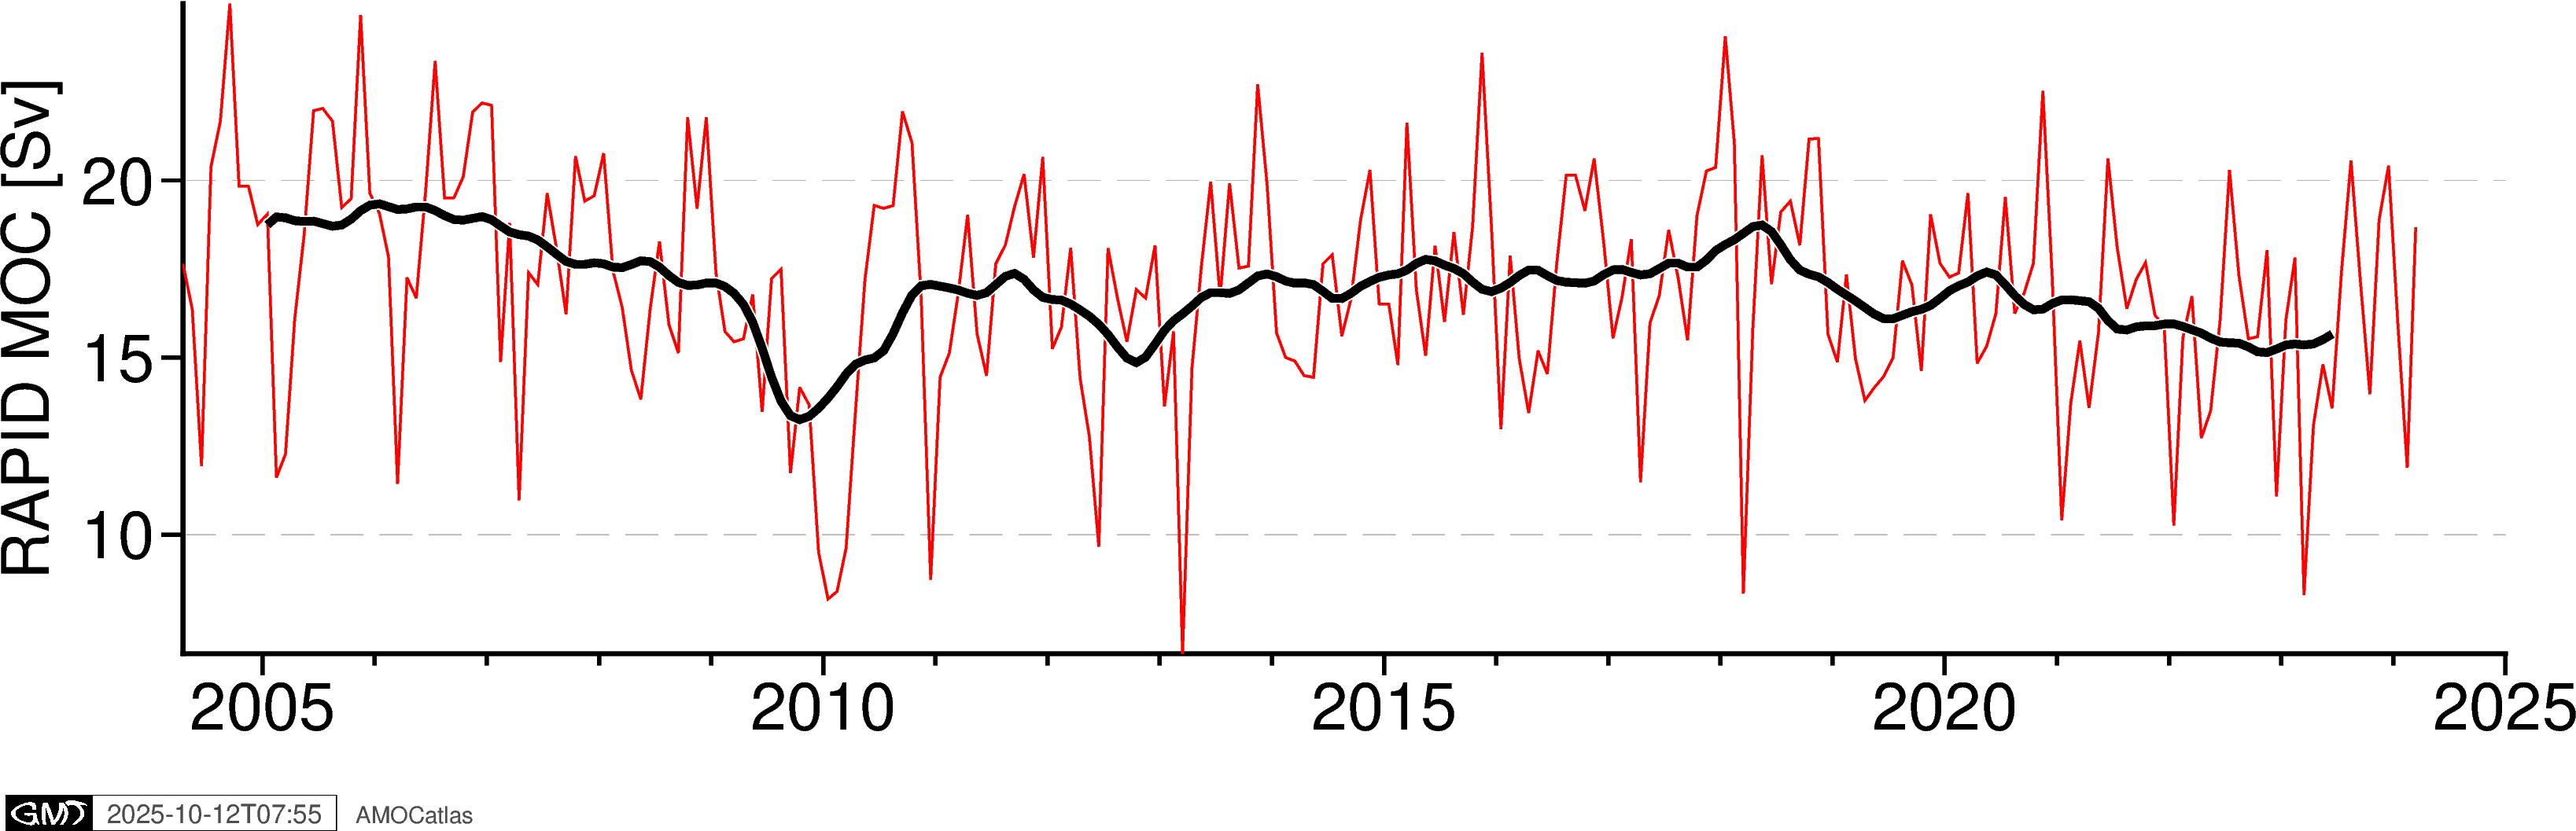

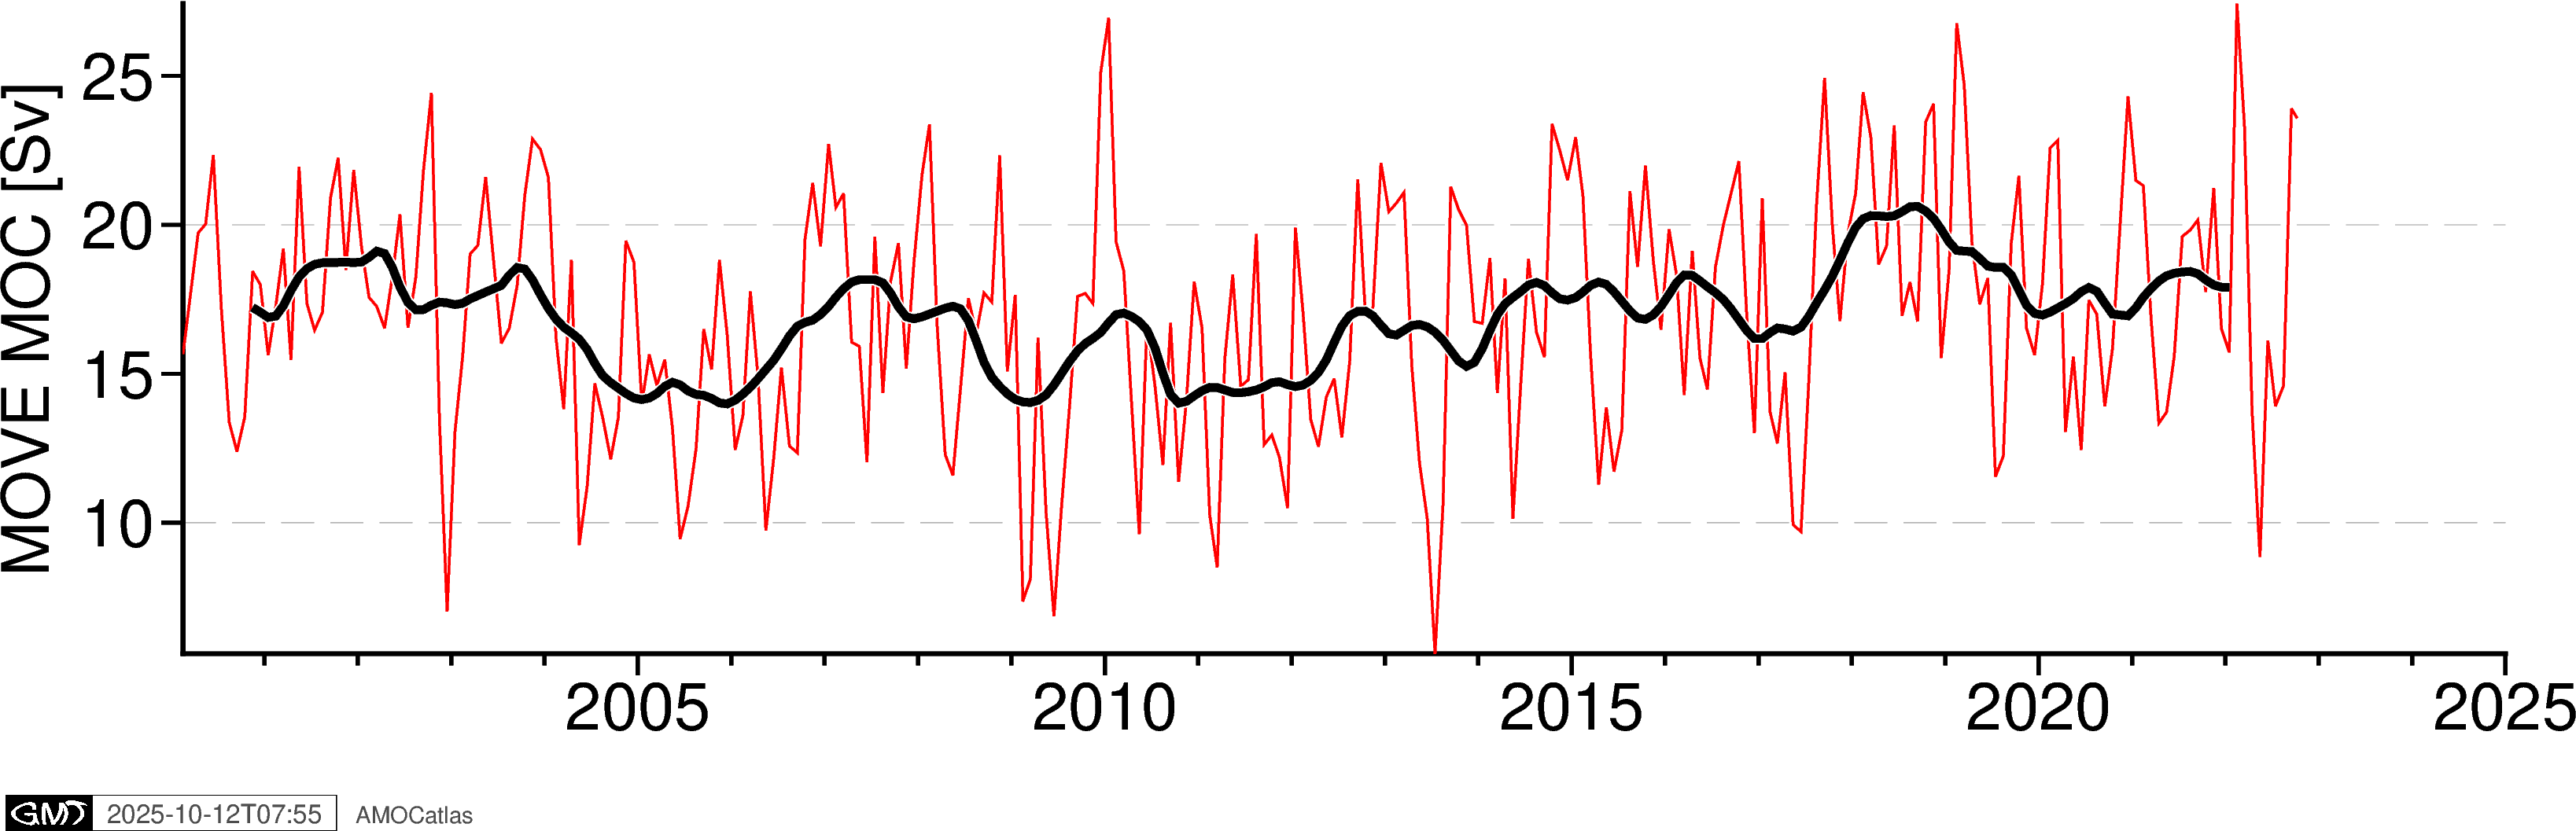

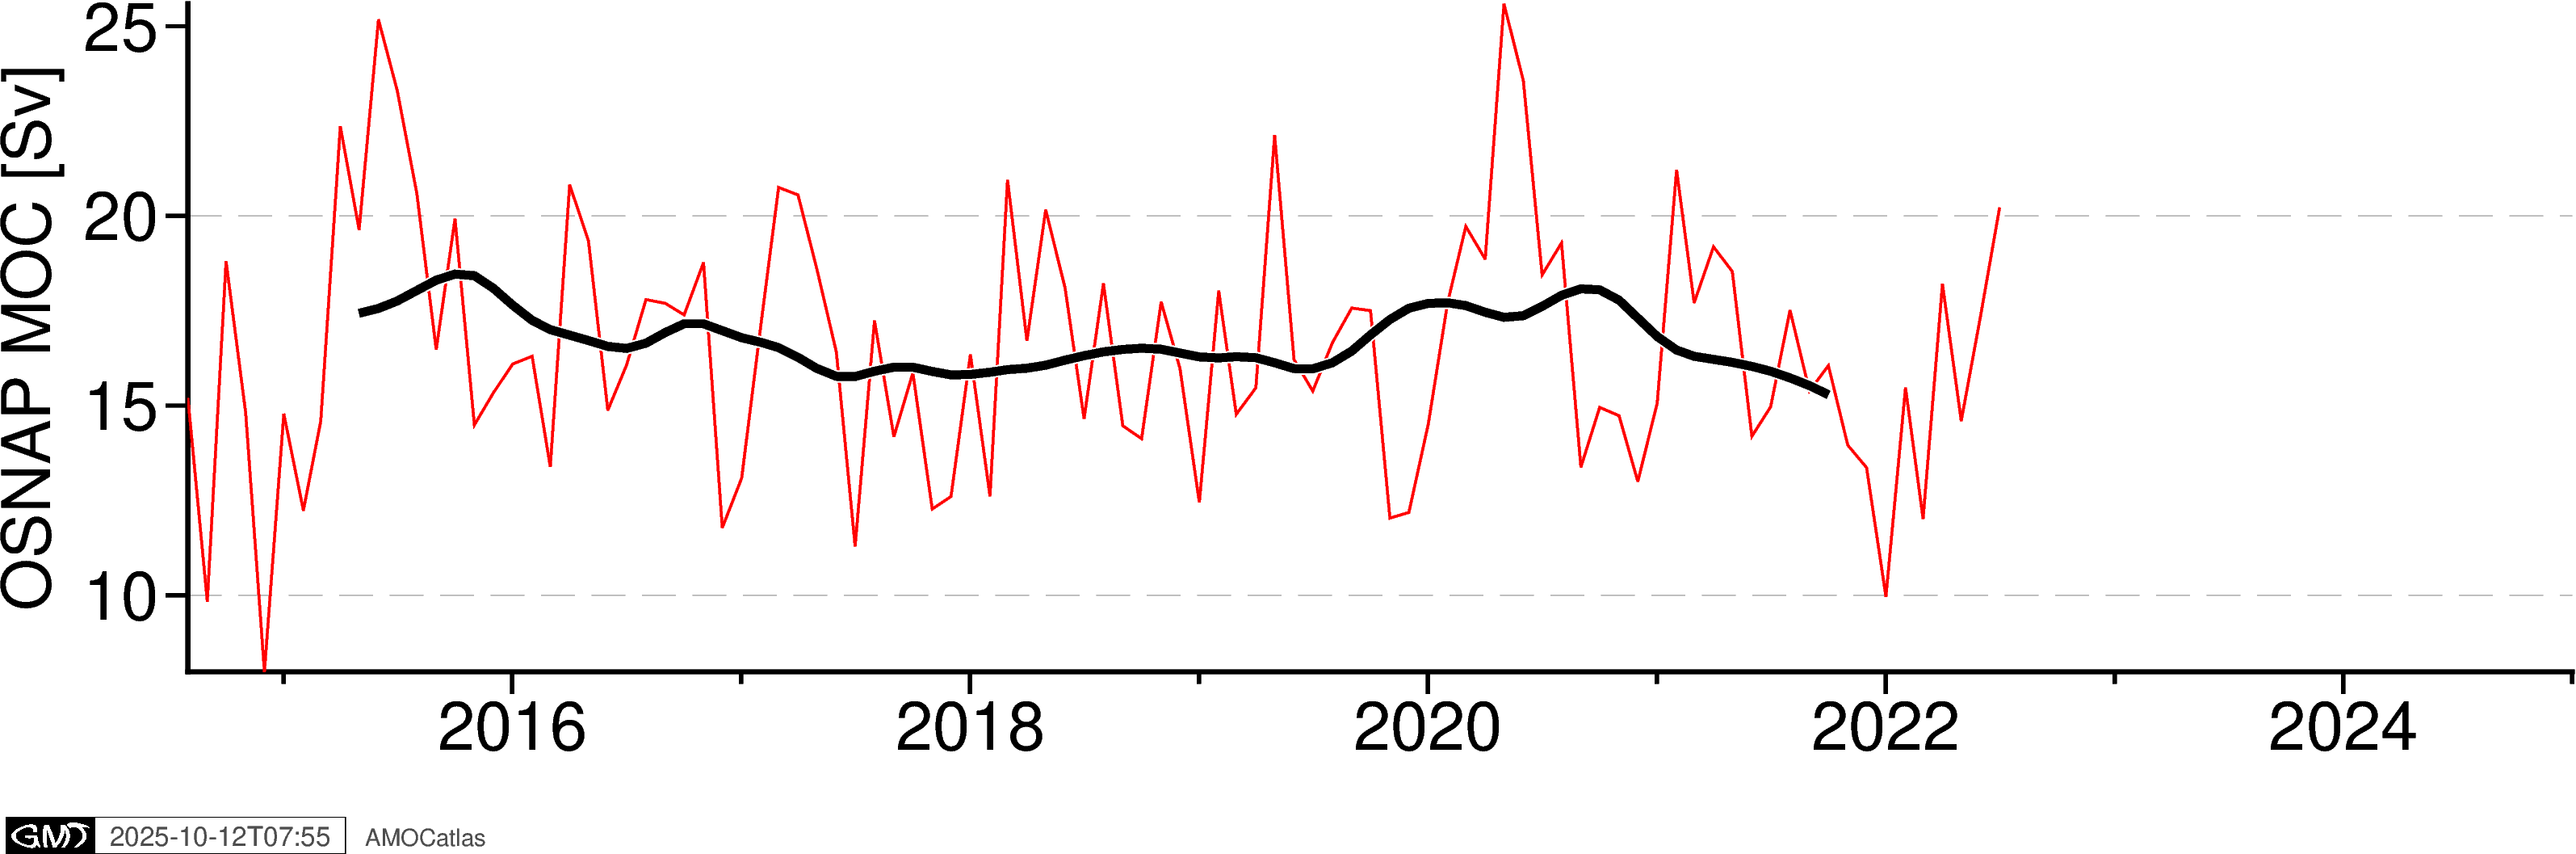

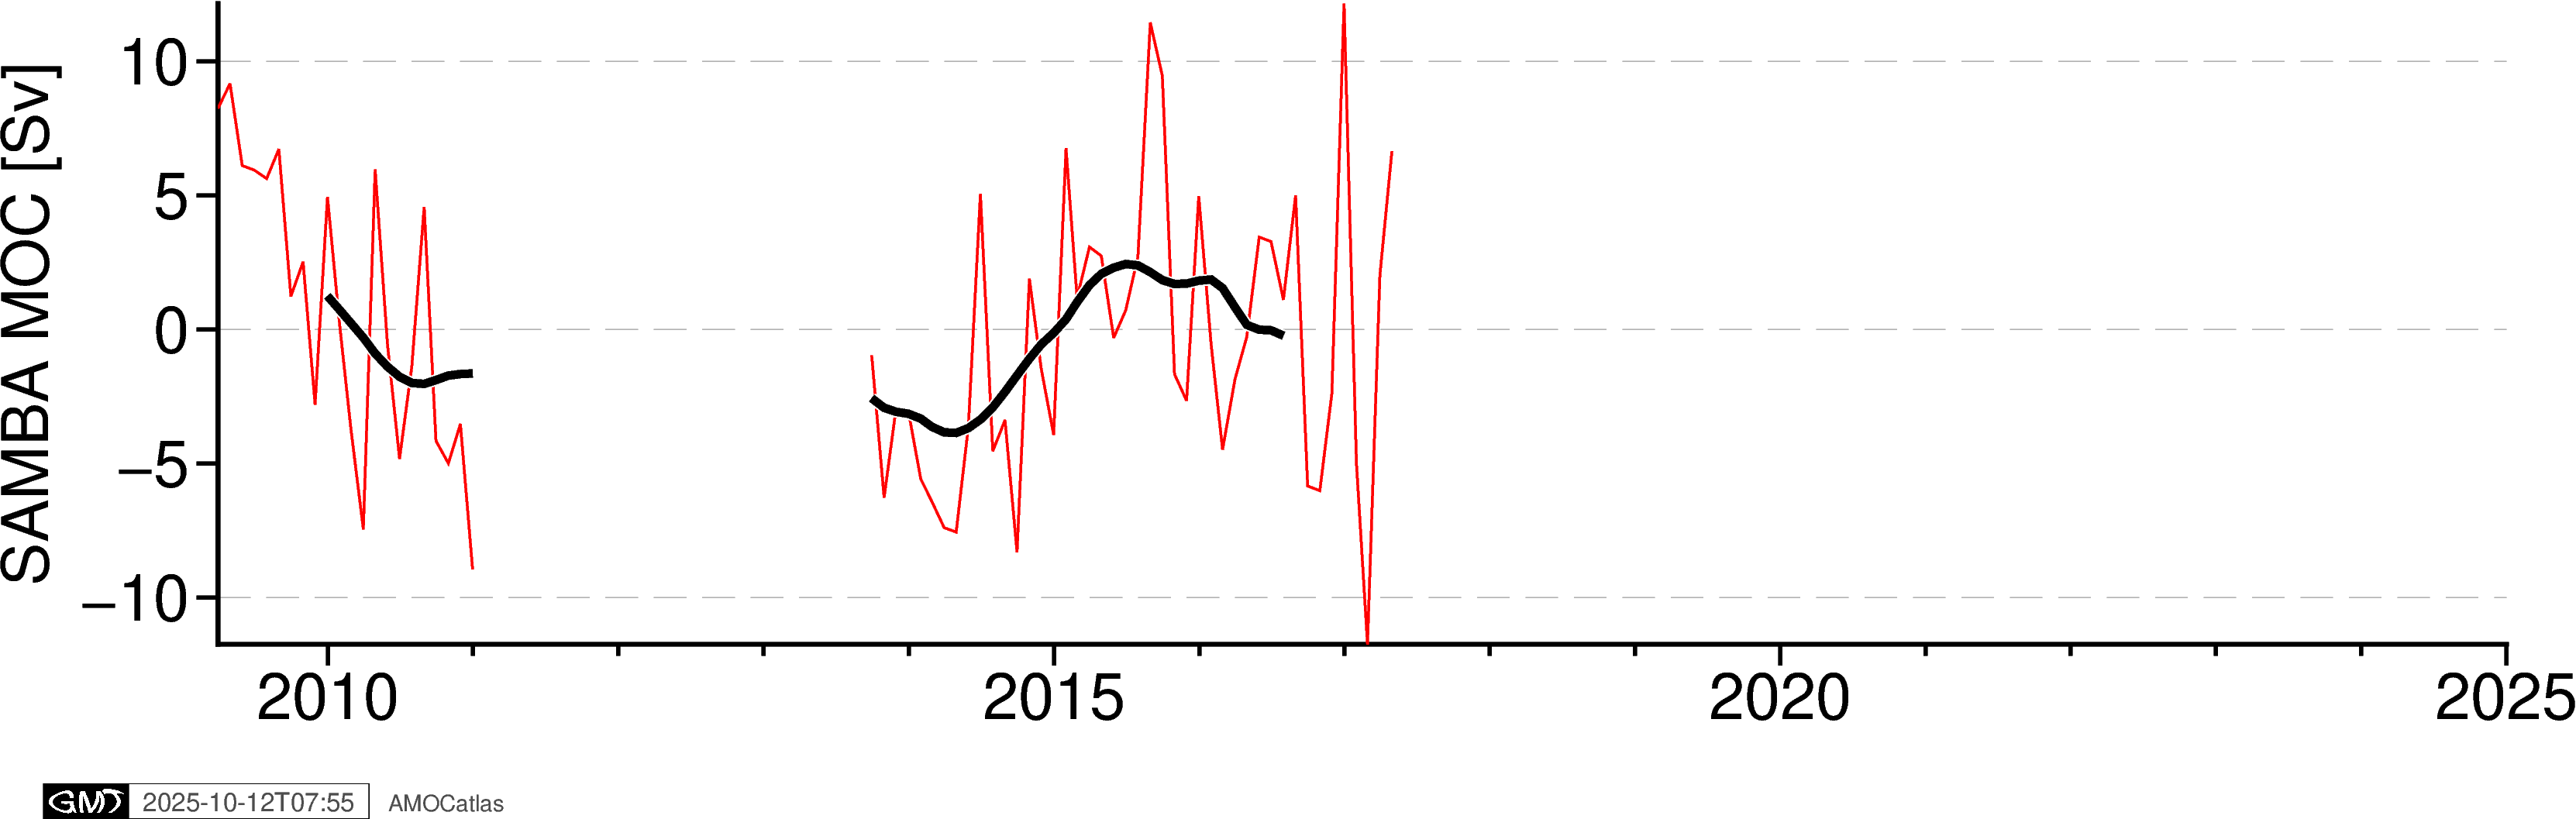

In [6]:
# Individual time series plots
try:
    fig_rapid = plotters.plot_moc_timeseries_pygmt(rapid_filtered, label="RAPID MOC [Sv]")
    fig_rapid.show()
    
    fig_move = plotters.plot_moc_timeseries_pygmt(move_filtered, label="MOVE MOC [Sv]")
    fig_move.show()
    
    fig_osnap = plotters.plot_moc_timeseries_pygmt(osnap_filtered, label="OSNAP MOC [Sv]")
    fig_osnap.show()
    
    fig_samba = plotters.plot_moc_timeseries_pygmt(samba_filtered, label="SAMBA MOC [Sv]")
    fig_samba.show()
    
except ImportError as e:
    print(f"PyGMT not available: {e}")
    print("Install with: pip install pygmt")

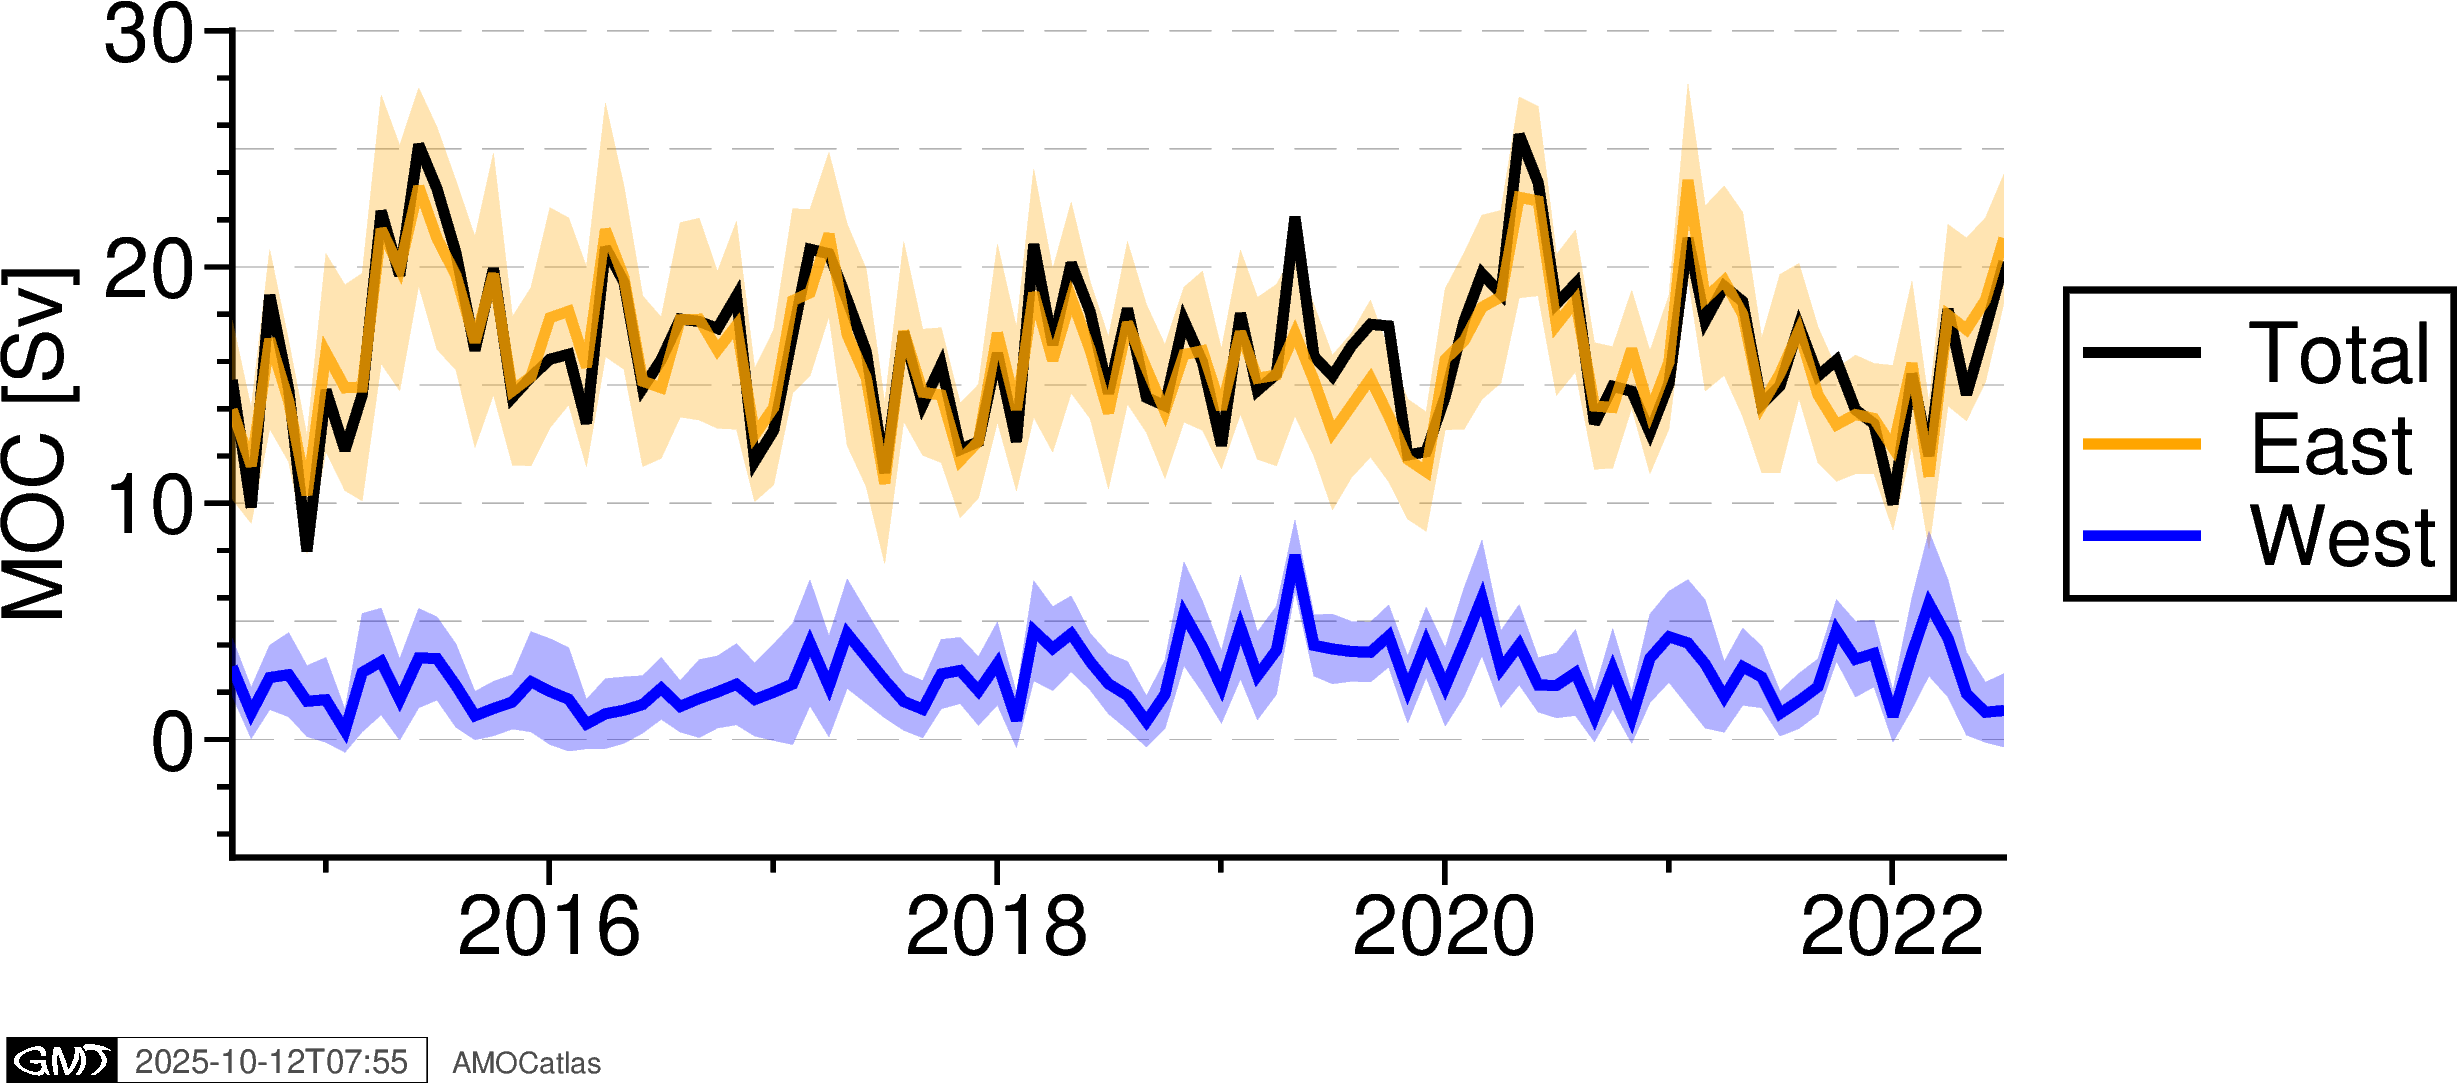

In [7]:
# OSNAP components plot with error bands
try:
    # Extract OSNAP component data
    ds = osnap_std[0]
    osnap_components = tools.extract_time_and_time_num(ds)
    
    # Add all OSNAP variables
    for var in ["MOC_ALL", "MOC_ALL_ERR", "MOC_EAST", "MOC_EAST_ERR", 
                "MOC_WEST", "MOC_WEST_ERR"]:
        osnap_components[var] = ds[var].values
    
    fig_osnap_comp = plotters.plot_osnap_components_pygmt(osnap_components)
    fig_osnap_comp.show()
    
    # Optional: save high-resolution version
    # fig_path = os.path.join(figures_dir, "osnap_components.png")
    # fig_osnap_comp.savefig(fig_path, dpi=300, transparent=True)
    # print(f"✓ Saved: {fig_path}")
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

# RAPID components plot
try:
    # Extract RAPID component data
    ds = rapid_std[0]
    rapid_components = tools.extract_time_and_time_num(ds)
    
    # Add transport components
    rapid_components["moc_mar_hc10"] = ds["moc_mar_hc10"].values
    rapid_components["t_gs10"] = ds["t_gs10"].values  # Florida Current
    rapid_components["t_ek10"] = ds["t_ek10"].values  # Ekman
    rapid_components["t_umo10"] = ds["t_umo10"].values  # Upper Mid-Ocean
    
    fig_rapid_comp = plotters.plot_rapid_components_pygmt(rapid_components)
    fig_rapid_comp.show()
    
    # Optional: save high-resolution version
    # fig_path = os.path.join(figures_dir, "rapid_components.png")
    # fig_rapid_comp.savefig(fig_path, dpi=300, transparent=True)
    # print(f"✓ Saved: {fig_path}")
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

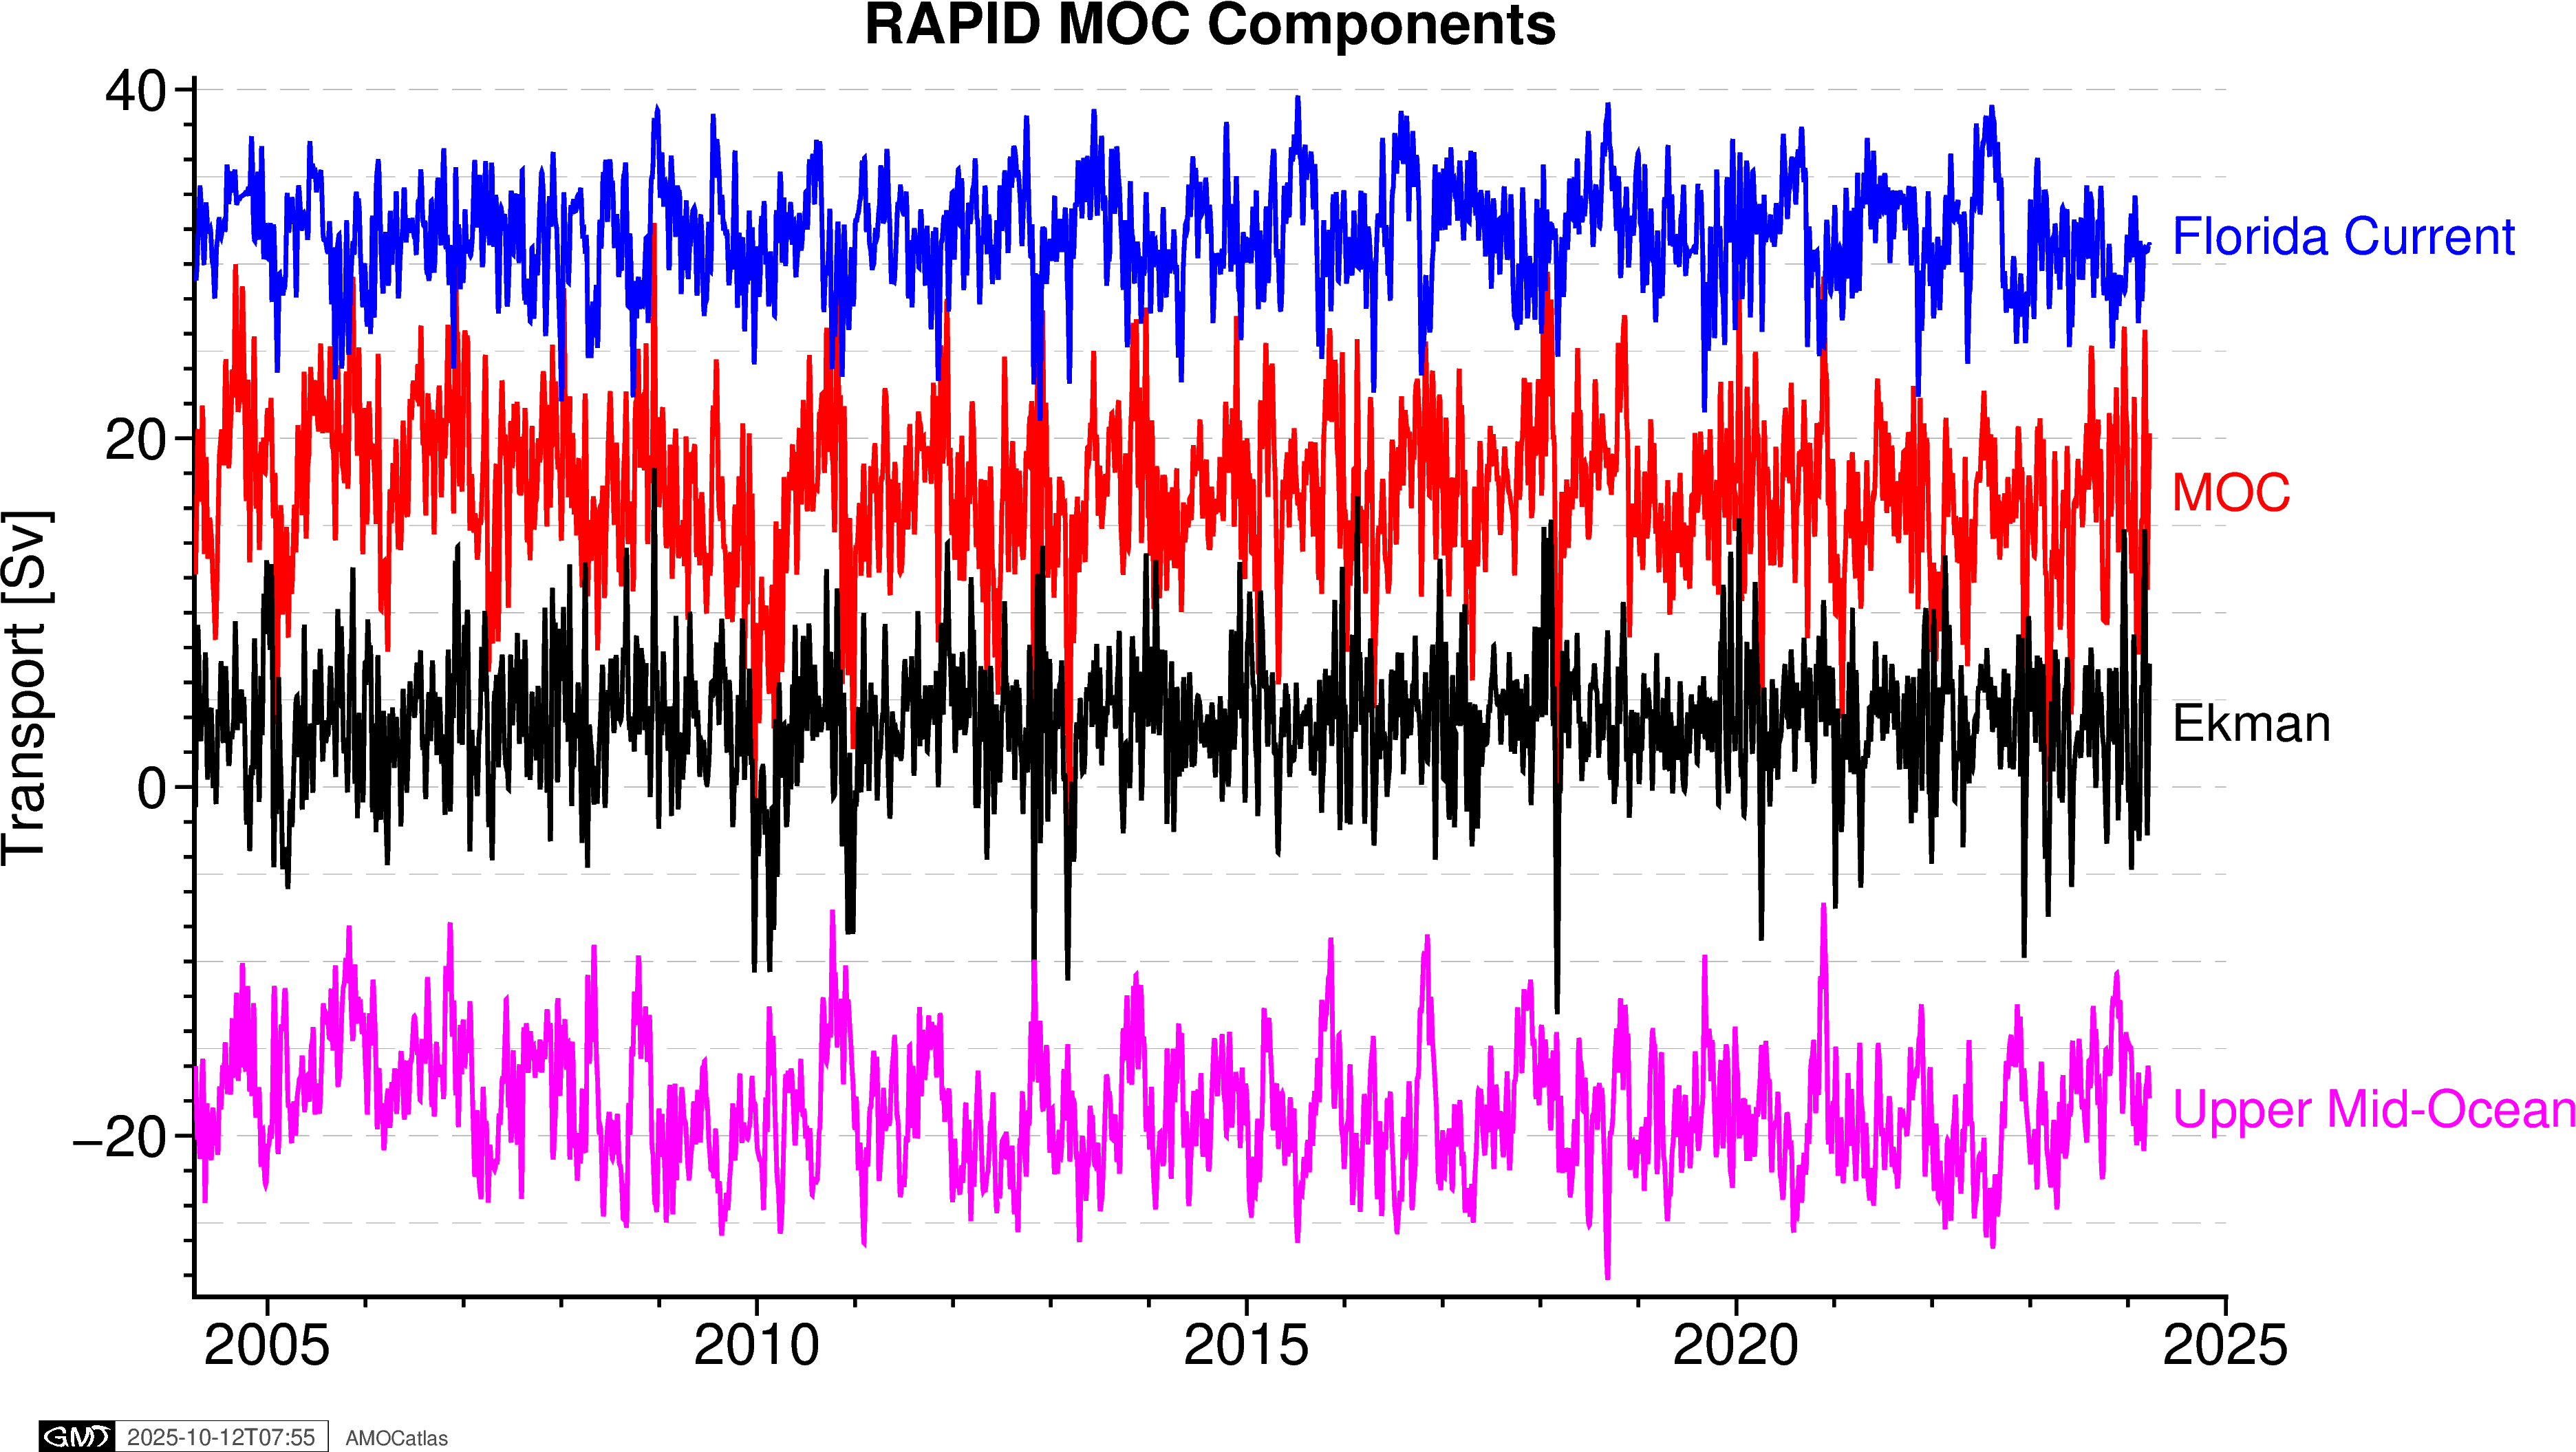

In [8]:
# RAPID components plot
try:
    # Extract RAPID component data
    ds = rapid_std[0]
    rapid_components = tools.extract_time_and_time_num(ds)
    
    # Add transport components
    rapid_components["moc_mar_hc10"] = ds["moc_mar_hc10"].values
    rapid_components["t_gs10"] = ds["t_gs10"].values  # Florida Current
    rapid_components["t_ek10"] = ds["t_ek10"].values  # Ekman
    rapid_components["t_umo10"] = ds["t_umo10"].values  # Upper Mid-Ocean
    
    fig_rapid_comp = plotters.plot_rapid_components_pygmt(rapid_components)
    fig_rapid_comp.show()
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

# Multi-array comparison plot - original data
try:
    fig_multi = plotters.plot_all_moc_pygmt(
        osnap_filtered, rapid_filtered, move_filtered, samba_filtered,
        filtered=False
    )
    fig_multi.show()
    
    # Save high-resolution version
    fig_path = os.path.join(figures_dir, "amoc_multi_array.png")
    fig_multi.savefig(fig_path, dpi=300, transparent=True)
    print(f"✓ Saved: {fig_path}")
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

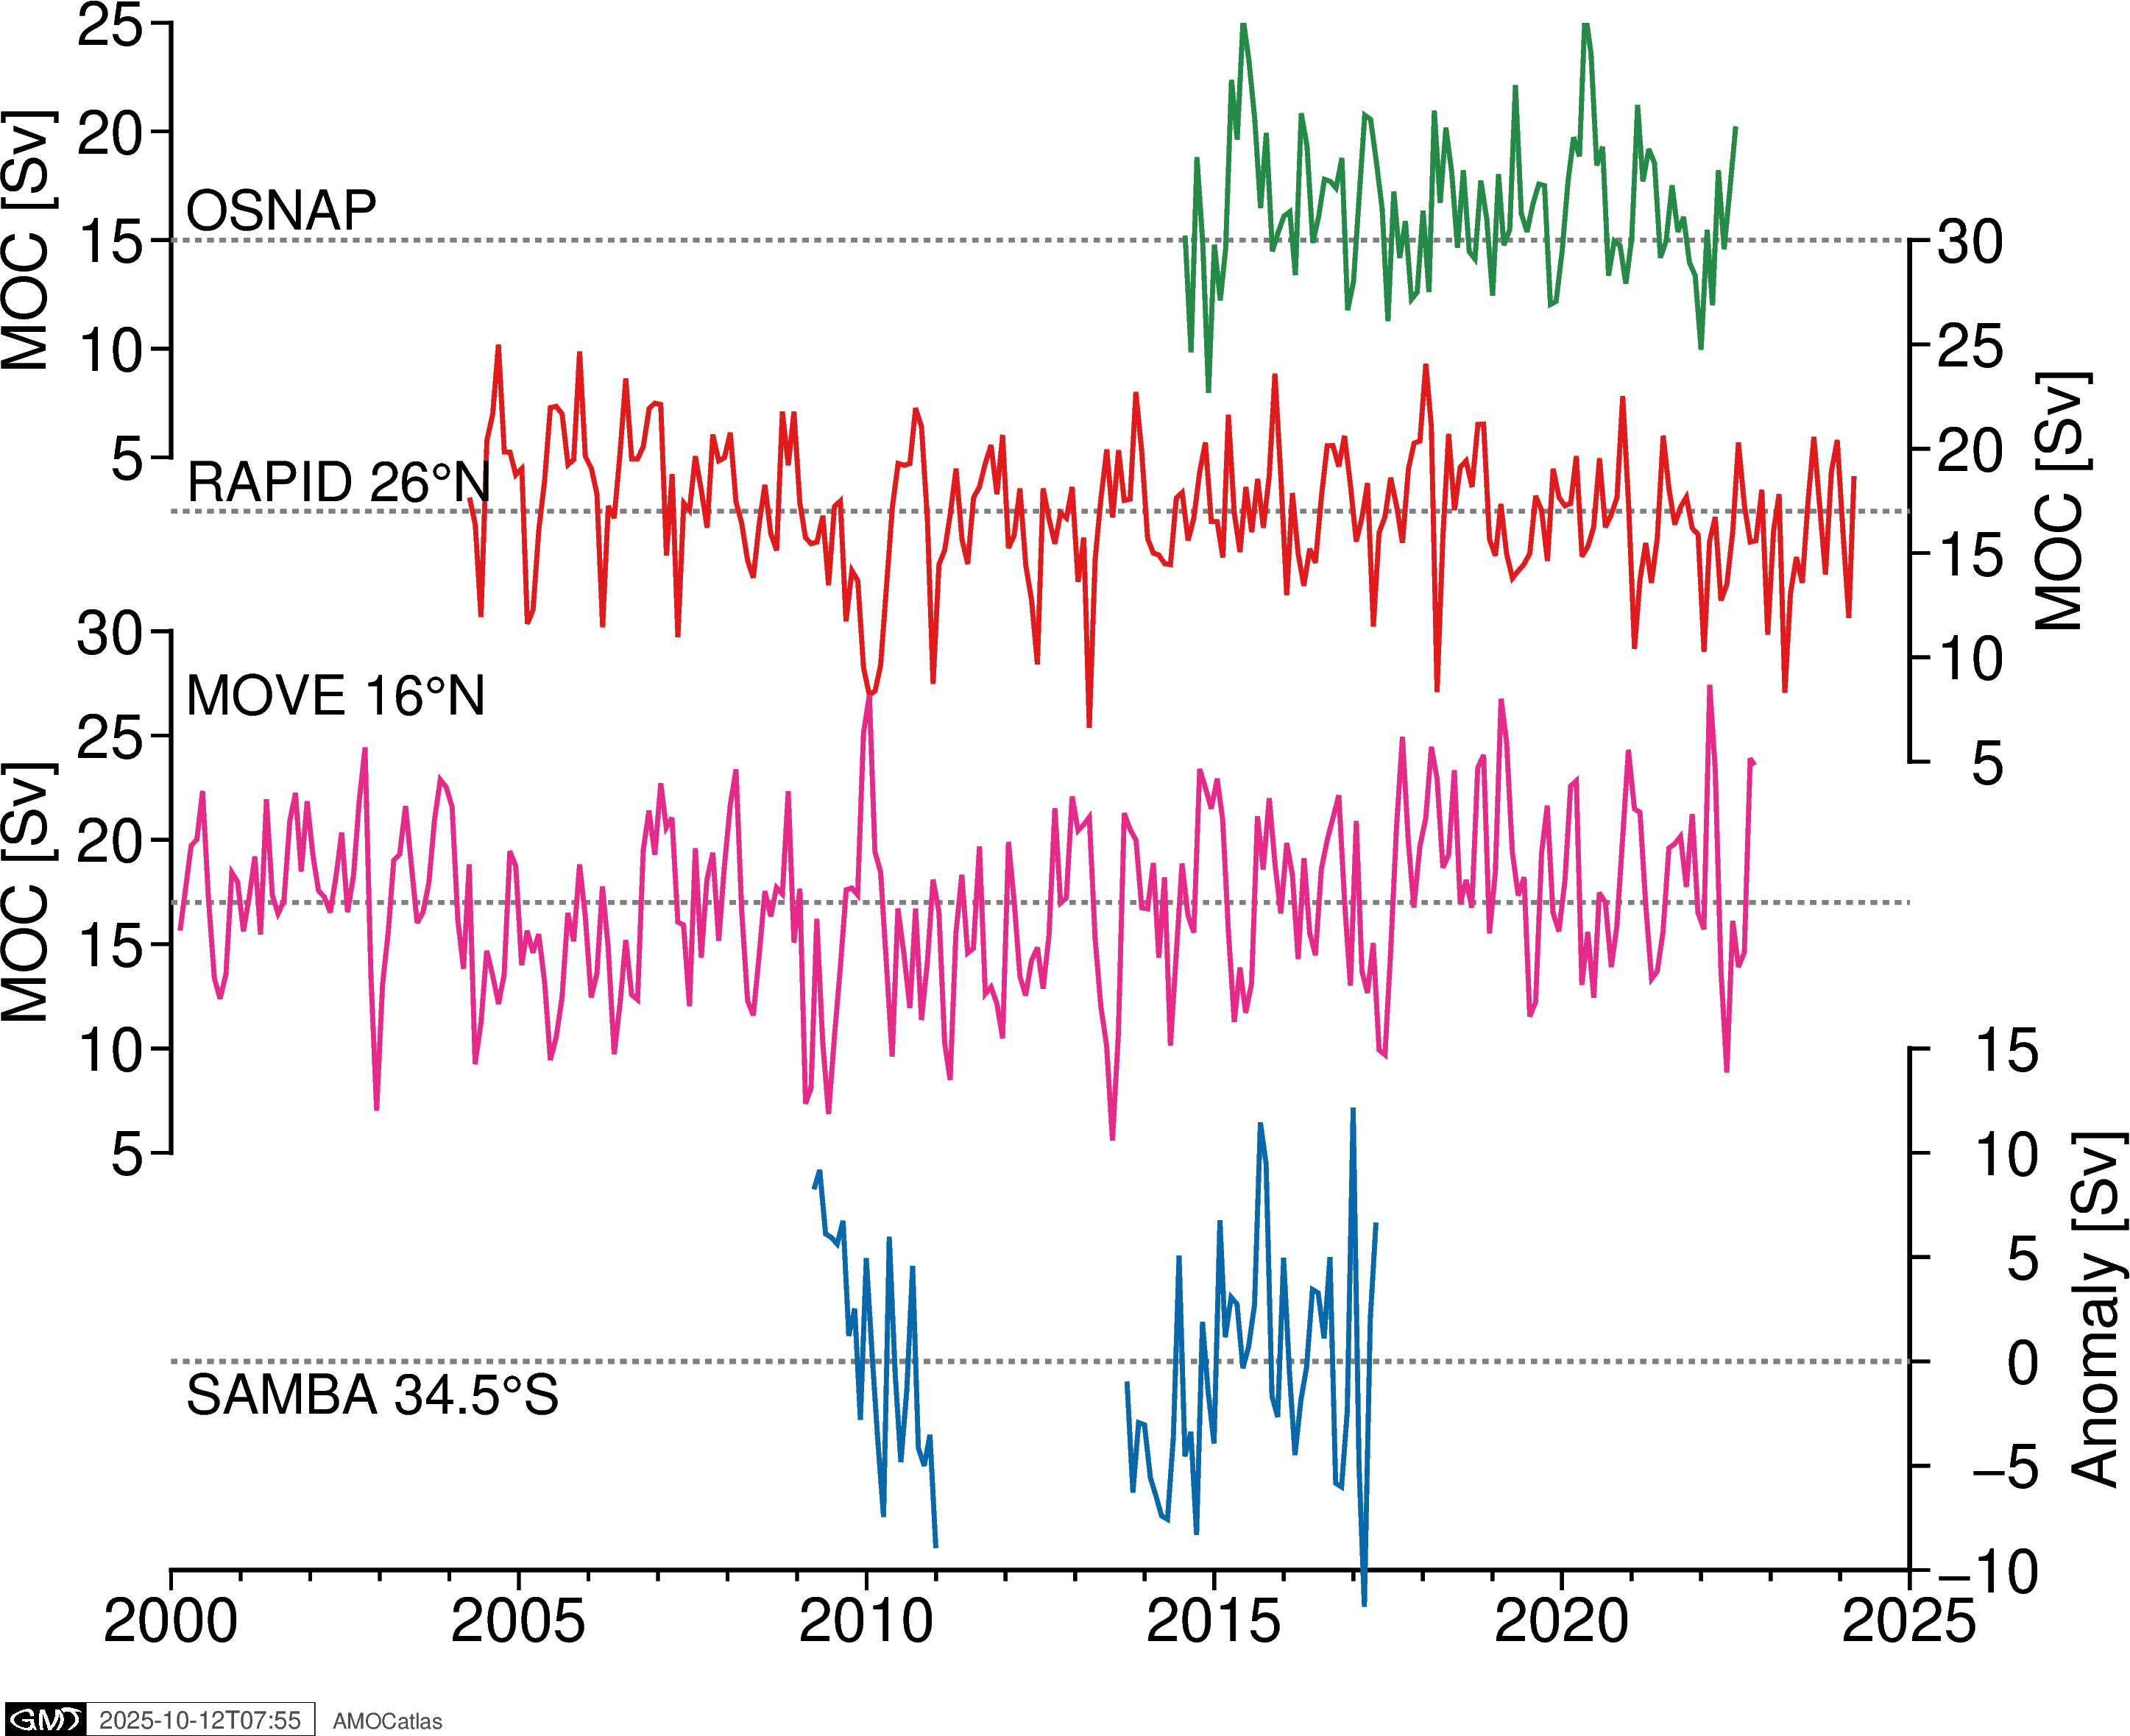

✓ Saved: ../docs/source/_static/paperfigs/amoc_multi_array.png


In [9]:
# Multi-array comparison plot - filtered data
try:
    fig_multi_filt = plotters.plot_all_moc_pygmt(
        osnap_binned, rapid_binned, move_binned, samba_binned,
        filtered=False
    )
    fig_multi_filt.show()
    
    # Save high-resolution version
    fig_path = os.path.join(figures_dir, "amoc_multi_array.png")
    fig_multi_filt.savefig(fig_path, dpi=300, transparent=True)
    print(f"✓ Saved: {fig_path}")
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

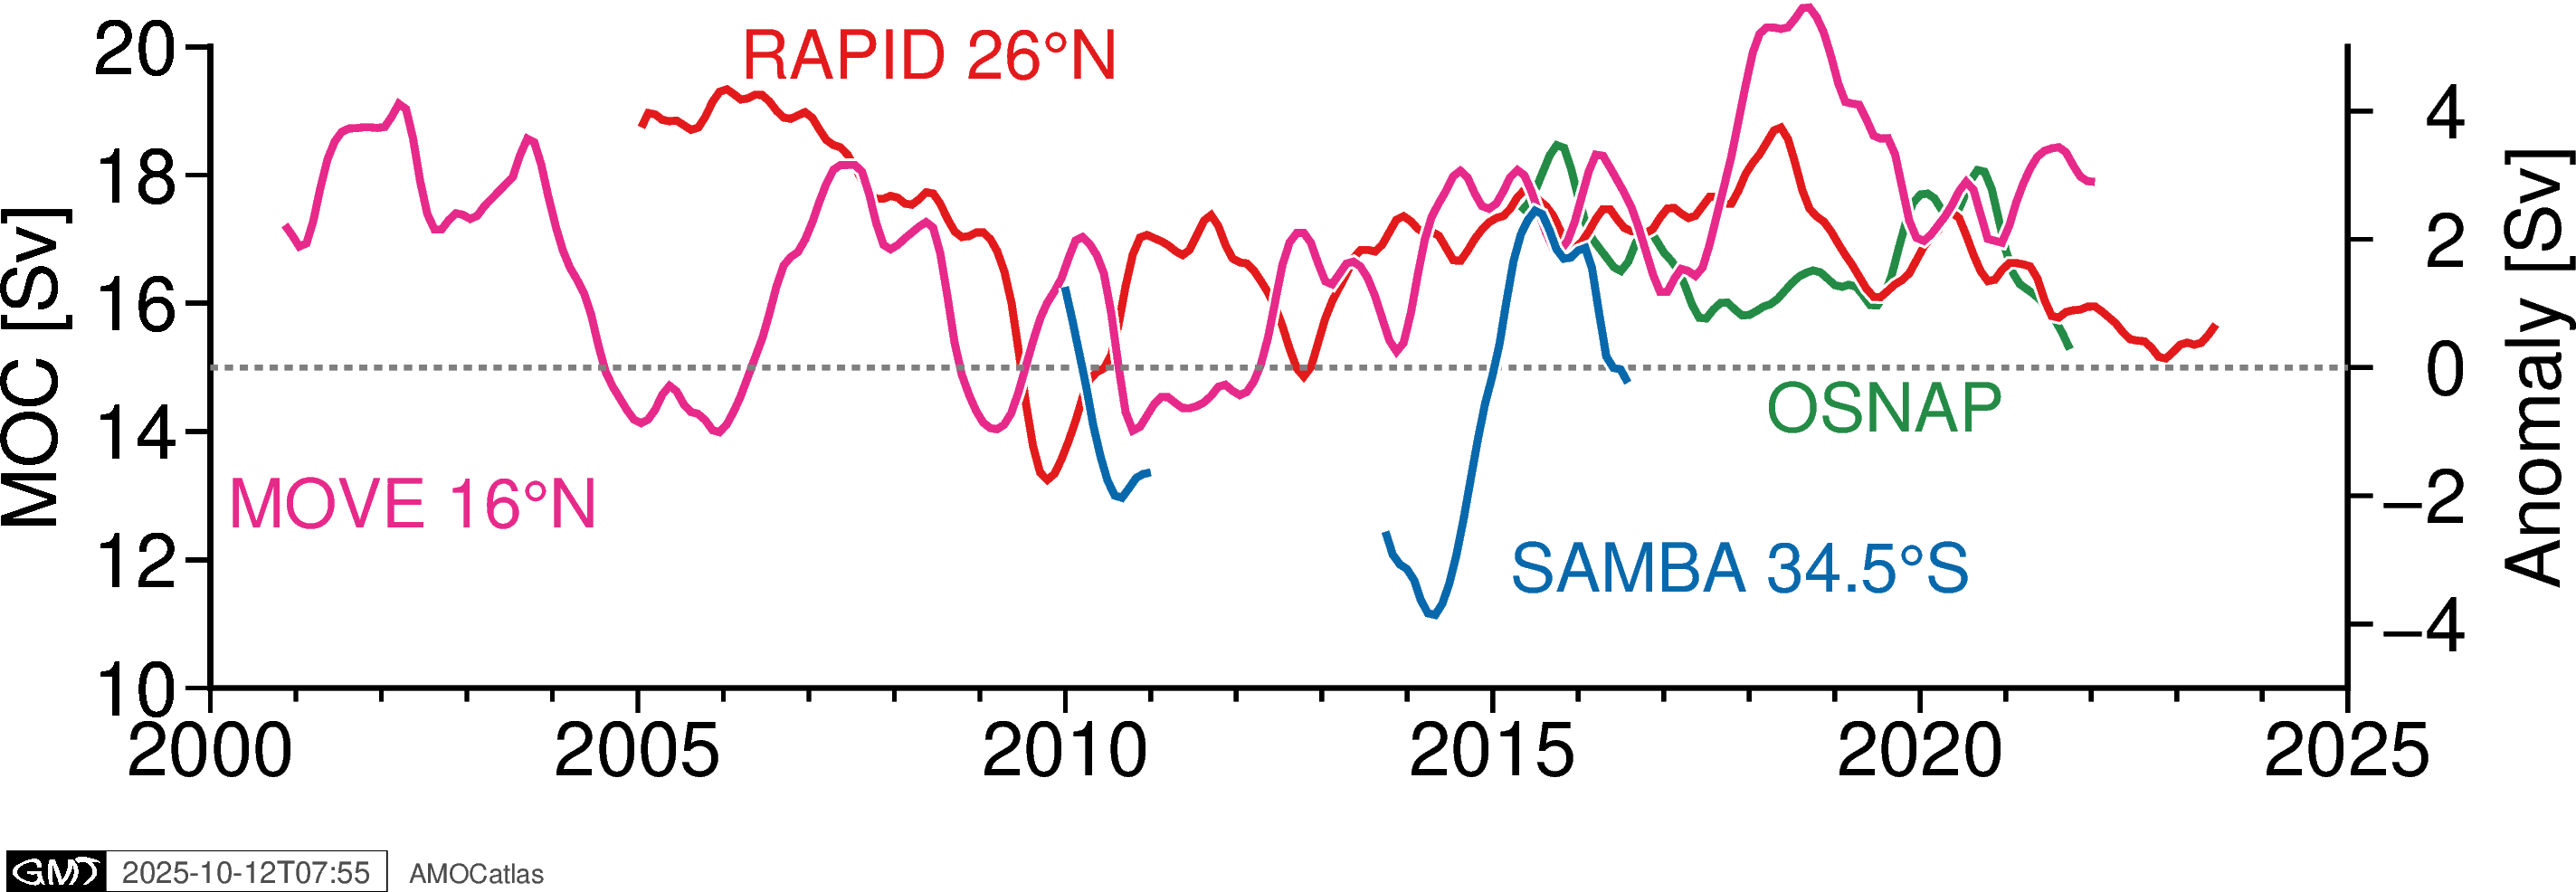

In [10]:
# Or overlaid, with SAMBA offset because it's an anomaly

fig_overlaid = plotters.plot_all_moc_overlaid_pygmt(
    osnap_filtered, rapid_filtered, move_filtered, samba_filtered,
    filtered=True
)

fig_overlaid.show()

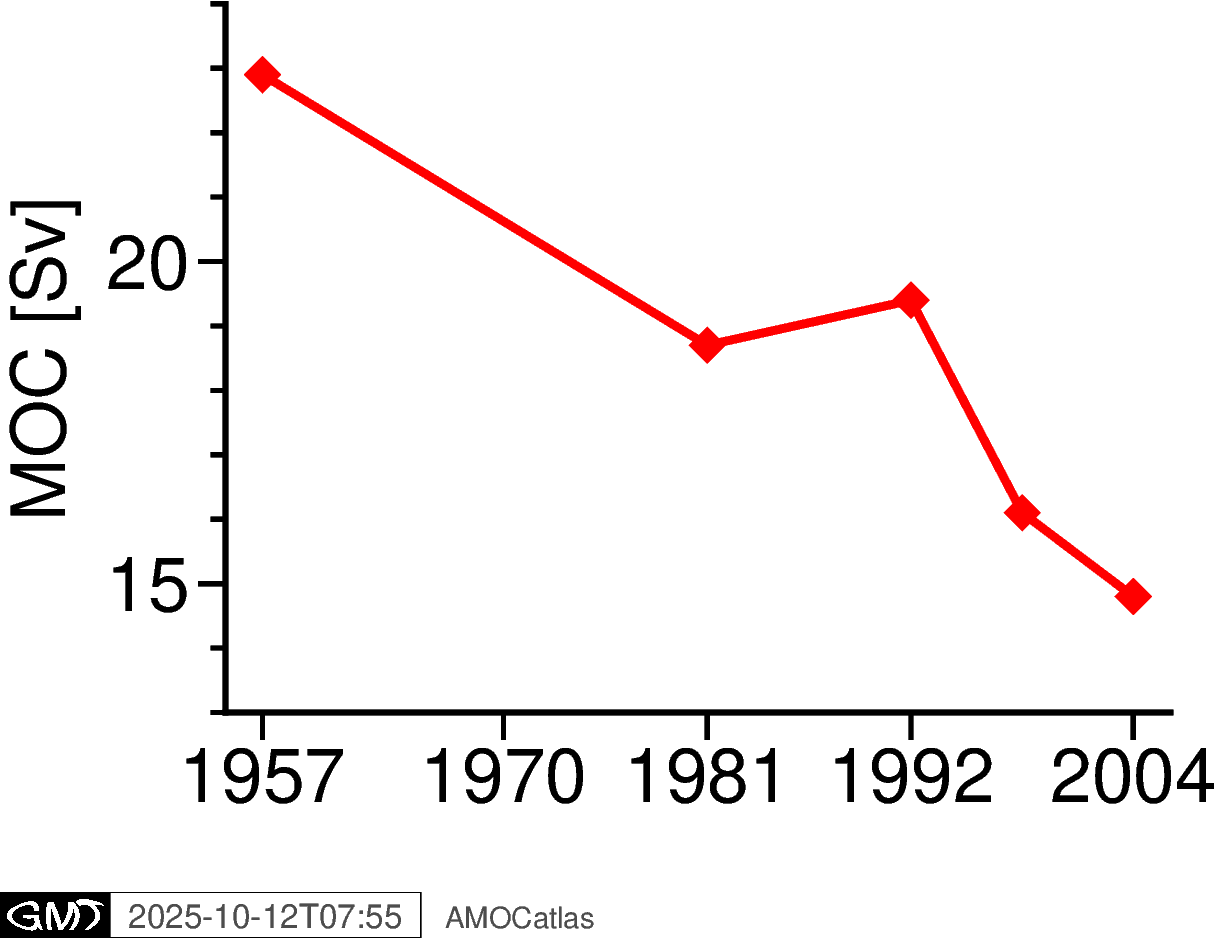

✓ Saved: ../docs/source/_static/paperfigs/bryden2005_amoc.png


In [11]:
# Historical AMOC estimates from Bryden et al. 2005
try:
    fig_bryden = plotters.plot_bryden2005_pygmt()
    fig_bryden.show()
    
    # Save high-resolution version
    fig_path = os.path.join(figures_dir, "bryden2005_amoc.png")
    fig_bryden.savefig(fig_path, dpi=300, transparent=True)
    print(f"✓ Saved: {fig_path}")
    
except ImportError as e:
    print(f"PyGMT not available: {e}")

## 10. Summary

This notebook demonstrates the streamlined workflow for creating publication-quality AMOC figures:

1. **Data Loading**: Using `readers.load_dataset()` for consistent data access
2. **Standardization**: Applying array-specific standardization functions
3. **Time Series Processing**: Converting to pandas with `tools.extract_time_and_time_num()`
4. **Gap Handling**: Using `tools.handle_samba_gaps()` to prevent plotting artifacts
5. **Filtering**: Applying Tukey filters with `tools.apply_tukey_filter()`
6. **Visualization**: Creating publication plots with `plotters.plot_*_pygmt()` functions

**Key Features:**
- Modular design using AMOCatlas functions
- Optional PyGMT dependency with graceful fallback
- Consistent styling across all plots
- Proper handling of temporal gaps in SAMBA data
- Historical context from Bryden et al. (2005)
- High-resolution export capability (saved to `docs/source/_static/paperfigs/`)
- Reproducible workflow for paper figures

**Publication Plots Created:**
- Individual array time series (RAPID, MOVE, OSNAP, SAMBA)
- OSNAP east/west component breakdown with error bands
- RAPID transport component analysis
- Multi-array comparison (original and filtered) → **saved for documentation**
- Historical AMOC estimates (Bryden 2005) → **saved for documentation**

**Note:** Since PyGMT installation can be challenging in CI environments, the key publication figures are saved to the documentation directory where they can be served to users through the project website.

## 9. Summary

This notebook demonstrates the streamlined workflow for creating publication-quality AMOC figures:

1. **Data Loading**: Using `readers.load_dataset()` for consistent data access
2. **Standardization**: Applying array-specific standardization functions
3. **Time Series Processing**: Converting to pandas with `tools.extract_time_and_time_num()`
4. **Filtering**: Applying Tukey filters with `tools.apply_tukey_filter()`
5. **Visualization**: Creating publication plots with `plotters.plot_*_pygmt()` functions

**Key Features:**
- Modular design using AMOCatlas functions
- Optional PyGMT dependency with graceful fallback
- Consistent styling across all plots
- High-resolution export capability
- Reproducible workflow for paper figures
